# Merging the remapped version of Bedmachine Antarctica with Gebco2

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import cartopy.crs as ccrs
import xesmf

In [2]:
#%matplotlib qt
%matplotlib inline

In [3]:
_ = xr.set_options(display_style='text')

## Load data files

In [4]:
bedmachine_remapped = xr.open_dataset('BedMachineAntarctica_elevation_nn_gebco_grid.nc')

In [5]:
gebco = xr.open_dataset('/work/Niki.Zadeh/datasets/topography/GEBCO_2014_2D.nc')

In [6]:
bedmachine_remapped

<xarray.Dataset>
Dimensions:    (lat: 3360, lon: 43200)
Coordinates:
  * lon        (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat        (lat) float64 -90.0 -89.99 -89.98 -89.97 ... -62.02 -62.01 -62.0
Data variables:
    elevation  (lat, lon) int16 ...

In [7]:
gebco

<xarray.Dataset>
Dimensions:    (lat: 21600, lon: 43200)
Coordinates:
  * lat        (lat) float64 -90.0 -89.99 -89.98 -89.97 ... 89.98 89.99 90.0
  * lon        (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    elevation  (lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    title:        The GEBCO_2014 Grid - a continuous terrain model for oceans...
    institution:  On behalf of the General Bathymetric Chart of the Oceans (G...
    source:       The bathymetric portion of the GEBCO_2014 Grid was largely ...
    history:      This is version 20150318 of the data set. Information on th...
    references:   Information on the data set is available from the GEBCO pro...
    comment:      The data in the GEBCO_2014 Grid should not be used for navi...
    node_offset:  1

GEBCO2 and Bedmachine do not have the same meridional extent so we're gonna pad bedmachine with zeros for the part north of 62S. First step is to extract the gebco coordinates for that part:

In [8]:
gebco_northof62S = gebco.sel(lat=slice(-62, 91))

In [9]:
gebco_southof62S = gebco.sel(lat=slice(-90, -62))

Make a sanity check:

In [10]:
lat_sum = gebco_southof62S['lat'].shape[0] + gebco_northof62S['lat'].shape[0]
lat_tot = gebco['lat'].shape[0]
test1 = np.equal(lat_sum, lat_tot)

lat_upper_bound_gebco_south = gebco_southof62S['lat'].max().values
lat_lower_bound_gebco_north = gebco_northof62S['lat'].min().values
test2 = (lat_upper_bound_gebco_south < lat_lower_bound_gebco_north)

test3 = np.allclose(gebco_southof62S['lat'], bedmachine_remapped['lat'])
if (not test1) or (not test2) or (not test3):
    print('latitude arrays do not match')
else:
    print('all tests passed')

all tests passed


## Create a linear transition:

In [11]:
lat = gebco_southof62S['lat']

latmax = lat.values.max()
latmin = -63
alpha_gebco = (lat - latmin) / (latmax - latmin)
alpha_gebco = xr.where(lat < latmin, 0, alpha_gebco)

alpha_bedmachine = 1 - alpha_gebco

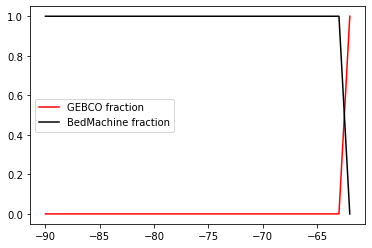

In [12]:
plt.plot(lat, alpha_gebco, 'r', label='GEBCO fraction')
plt.plot(lat, alpha_bedmachine, 'k', label='BedMachine fraction')
plt.legend()

## Proceed to merge and save dataset

In [13]:
merged_elevation_south = (alpha_gebco * gebco_southof62S['elevation'] +
                          alpha_bedmachine * bedmachine_remapped['elevation'])

In [14]:
merged_elevation_fullglobe = xr.concat([merged_elevation_south,
                                        gebco_northof62S['elevation']],
                                        dim='lat')

In [18]:
merged_bathy = xr.Dataset()
merged_bathy['elevation'] = merged_elevation_fullglobe
merged_bathy['elevation'].attrs = {'standard_name': 'height_above_reference_ellipsoid',
                                   'long_name': 'Elevation relative to sea level',
                                   'units': 'm'}
# gebco is given in type short, which basically is equivalent to integer values,
# hence no need to save decimal points...
encoding = {'elevation': {'dtype': np.int16, '_FillValue': 32767},
            'lon': {'_FillValue': 1.0e+20},
            'lat': {'_FillValue': 1.0e+20}}
merged_bathy.to_netcdf('merged_BedMachineAntarctic_GEBCO2.nc',
                       encoding=encoding)

## Some plotting to check results

We can start with a global plot (50x subsampled) to check for large scale discrepancies:

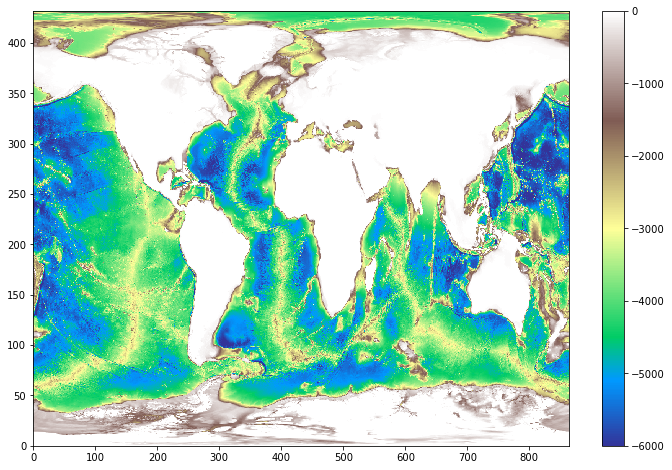

In [19]:
plt.figure(figsize=[12,8])
plt.pcolormesh(merged_bathy['elevation'].values[::50,::50],
               vmin=-6000, vmax=0, cmap='terrain')
plt.colorbar()

Next produce a serie (72 plots) of 600x600 points for detailed checking, remember the transition is happening between 63S and 62S:

In [20]:
bathyzoom = merged_bathy.sel(lat=slice(-65,-60))

def plot_detailed(bathyzoom, k):
    imin=k*600
    imax=(k+1)*600
    kstr = str(k).zfill(2)
    plt.figure(figsize=[12,8])
    plt.pcolormesh(bathyzoom['lon'].values[imin:imax],
                   bathyzoom['lat'].values[:],
                   bathyzoom['elevation'].values[:,imin:imax],
                   vmin=-6000, vmax=0, cmap='terrain')
    plt.colorbar()
    plt.savefig(f'merged_transition_{kstr}.png')
    plt.close()

In [22]:
%matplotlib qt

In [23]:
for k in range(72):
    plot_detailed(bathyzoom, k)